In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import os

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

np.set_printoptions(linewidth=np.inf, suppress=True, precision=2)

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score 

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import tensorflow as tf

from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel)
from sklearn.gaussian_process import GaussianProcessRegressor  
from sklearn.svm import SVR

In [4]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

pyo.init_notebook_mode(connected=True)

In [5]:
from solver import deasolver

In [ ]:
results = []
df_imp = pd.DataFrame()

In [ ]:
path = "Data/RealData/eGrid/recent/"

In [ ]:
df = pd.read_excel(path + "egrid2020_data.xlsx", sheet_name="PLNT20", usecols="D, W, AB, AL, AN, AP, AR, AS, AT, AU").drop(0)

In [ ]:
# os.listdir(path)

In [ ]:
# df= pd.DataFrame()
# i=0
# for file in os.listdir(path):
#     if os.path.splitext(file)[1] == ".xlsx" and not "copy" in file:
#         df_temp = pd.read_excel(path + file, sheet_name=3, usecols="D, W, AB, AL, AN, AP, AR, AS, AT, AU").drop(0)
#         df = pd.concat([df, df_temp], ignore_index=True)
#         print(i)

In [ ]:
df.set_index("Plant name", inplace=True)
df.dropna(inplace=True)

In [ ]:
df = df[(df!=0).all(axis=1)]

In [ ]:
for col in df.columns:
    df[col] = df[col].astype("float")

In [ ]:
def find_outliers(df_in, col_name):
    Q1 = df_in[col_name].quantile(0.25)
    Q3 = df_in[col_name].quantile(0.75)
    IQR = Q3-Q1
    fence_low  = Q1-1.5*IQR
    fence_high = Q3+1.5*IQR
    outlier_indexes=df_in[(df_in[col_name] <= fence_low) | (df_in[col_name] >= fence_high)].index.tolist()
    return outlier_indexes

bad_indexes=[]
for col in df.columns:
    if df[col].dtype in ["int64", "float64"]:
        outlierindexes= find_outliers(df, col)
        bad_indexes.extend(outlierindexes)
bad_index_list = list(set(bad_indexes))
print(f"All Bad indexes:{bad_index_list[:5]}")  

In [ ]:
len(bad_index_list)

In [ ]:
df.drop(bad_index_list, inplace=True)

In [ ]:
df.shape

In [ ]:
df.corr()

In [ ]:
df.index.name = None

In [ ]:
df

In [ ]:
df.columns

In [ ]:
df.columns = ['Number of generators', 'Plant nameplate capacity (MW)',
       'Plant total annual heat input (MMBtu)',
       'Plant annual NOx emissions (tons)',
       'Plant annual SO2 emissions (tons)',
       'Plant annual CO2 emissions (tons)', 'Plant annual CH4 emissions (lbs)',
       'Plant annual N2O emissions (lbs)',
       'Plant annual net generation (MWh)']

In [ ]:
df.columns = ["Output_" + col if "MWh" in col else "Input_" + col for col in df.columns]

In [ ]:
df.to_excel(path + 'egrid2020_data_copy_1.xlsx')

In [ ]:
df = pd.read_excel(path + 'egrid2020_data_copy_1.xlsx', index_col=0)
df

In [ ]:
df.info()

In [ ]:
deasolver(inputfile = path + 'egrid2020_data_copy_1.xlsx', folder = "Data/RealData/eGrid/recent/", out_suffix1="_Sol")

In [15]:
df_weights = pd.read_excel("Data/RealData/eGrid/recent/egrid2020_data_copy_1_Sol.xlsx", index_col = 0).iloc[:, 1:]

In [ ]:
df_zero =(df_weights==0).sum()
df_zero

### ML

In [ ]:
X = df.iloc[:,:-1]
X.head()

In [ ]:
y = df.iloc[:,-1:]
y.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

In [ ]:
gb_model = GradientBoostingRegressor(random_state=42)

pipe_gb = make_pipeline(std_scaler, gb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="r2").mean())

In [ ]:
learning_rate = [1, 0.5, 0.1,  0.01]
n_estimators = [50, 100, 200, 500, 1000, 2000]
max_depth = [3, 5, 10, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
subsample = [0.3, 0.5, 0.75, 1.0]

In [ ]:
# specify parameter values to search
params = {}
params['gradientboostingregressor__learning_rate'] = learning_rate
params['gradientboostingregressor__n_estimators'] = n_estimators
params['gradientboostingregressor__max_depth'] = max_depth
params['gradientboostingregressor__min_samples_split'] = min_samples_split
params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
params['gradientboostingregressor__subsample'] = subsample

In [ ]:
grid = RandomizedSearchCV(pipe_gb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=1)
grid.fit(X, y.values.ravel())

In [ ]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

In [ ]:
imp_gb = grid.best_estimator_.steps[1][1].feature_importances_
imp_gb

In [ ]:
df_gb = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_gb}).sort_values("Importance", ascending=False)
df_gb

In [ ]:
input_imp = list(df_gb["Feature Name"].values)
results.append((0, grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_}))

In [ ]:
fig = px.bar(df_gb, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=600,
    height=300,
    title_text=f"GradientBoostingRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [ ]:
df_gb

In [ ]:
df_zero.index = ["_".join(f.split("_")[1:]) for f in df_zero.index]

In [ ]:
df_zero

In [ ]:
df_merged = pd.merge(df_gb, df_zero.reset_index(), left_on="Feature Name", right_on="index")
df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
df_merged

In [ ]:
fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"GradientBoostingRegressor Feature Importance - Zero_Count Relationship",
)

fig.show()

In [ ]:
plt.figure(figsize=(18,12))
sns.heatmap(df_weights.eq(0).transpose(),
        cmap="YlGnBu",
        cbar=False,
        cbar_kws={'label': 'Zero Values'});

In [ ]:
results 

In [ ]:
deasolver(inputfile="Data/RealData/eGrid/recent/egrid2020_data_copy_1.xlsx", folder = "Data/RealData/eGrid/recent/", out_suffix1="_Sol_1", input_imp = results[0])

In [9]:
df_weights_1 = pd.read_excel("Data/RealData/eGrid/recent/egrid2020_data_copy_1_Sol_1.xlsx", index_col = 0).iloc[:, 1:]

In [16]:
df_es = pd.read_excel("Data/RealData/eGrid/recent/egrid2020_data_copy_1_Sol.xlsx", index_col = 0).iloc[:, :1]
df_es_1 = pd.read_excel("Data/RealData/eGrid/recent/egrid2020_data_copy_1_Sol_1.xlsx", index_col = 0).iloc[:, :1]

In [17]:
es = (df_es.Efficiency_Scores==1).sum()
print(f"count of efficient units : {es}")

count of efficient units : 22


In [18]:
es_1 = (df_es_1.Efficiency_Scores==1).sum()
print(f"count of efficient units : {es_1}")

count of efficient units : 2


In [19]:
df_zero =(df_weights==0).sum()
df_zero

Weight_Input_Number of generators                     1065
Weight_Input_Plant annual CH4 emissions (lbs)         1677
Weight_Input_Plant annual CO2 emissions (tons)         982
Weight_Input_Plant annual N2O emissions (lbs)           16
Weight_Input_Plant annual NOx emissions (tons)         721
Weight_Input_Plant annual SO2 emissions (tons)        1219
Weight_Input_Plant nameplate capacity (MW)            1153
Weight_Input_Plant total annual heat input (MMBtu)    1196
Weight_Output_Plant annual net generation (MWh)          0
dtype: int64

In [20]:
df_zero =(df_weights_1==0).sum()
df_zero

Weight_Input_Number of generators                     823
Weight_Input_Plant annual CH4 emissions (lbs)         526
Weight_Input_Plant annual CO2 emissions (tons)        523
Weight_Input_Plant annual N2O emissions (lbs)           0
Weight_Input_Plant annual NOx emissions (tons)         54
Weight_Input_Plant annual SO2 emissions (tons)        807
Weight_Input_Plant nameplate capacity (MW)            654
Weight_Input_Plant total annual heat input (MMBtu)    117
Weight_Output_Plant annual net generation (MWh)         0
dtype: int64

In [22]:
df_res = df_es.join(df_es_1, lsuffix = "_Basic", rsuffix="_with_ML")

In [24]:
df_res["Diff"] = df_res["Efficiency_Scores_Basic"]  - df_res["Efficiency_Scores_with_ML"]
df_res["Diff_Perc"] = (df_res["Diff"] / df_res["Efficiency_Scores_Basic"]) * 100 
df_res["Diff_Perc < 10"] = np.abs(df_res["Diff_Perc"]) < 10  
df_res = df_res.round(4)

In [25]:
blue = df_res["Diff_Perc < 10"].sum()
print("blue : ", blue)
red = len(df_res["Diff_Perc < 10"]) - (df_res["Diff_Perc < 10"].sum())
print("red : ", red)

blue :  886
red :  847


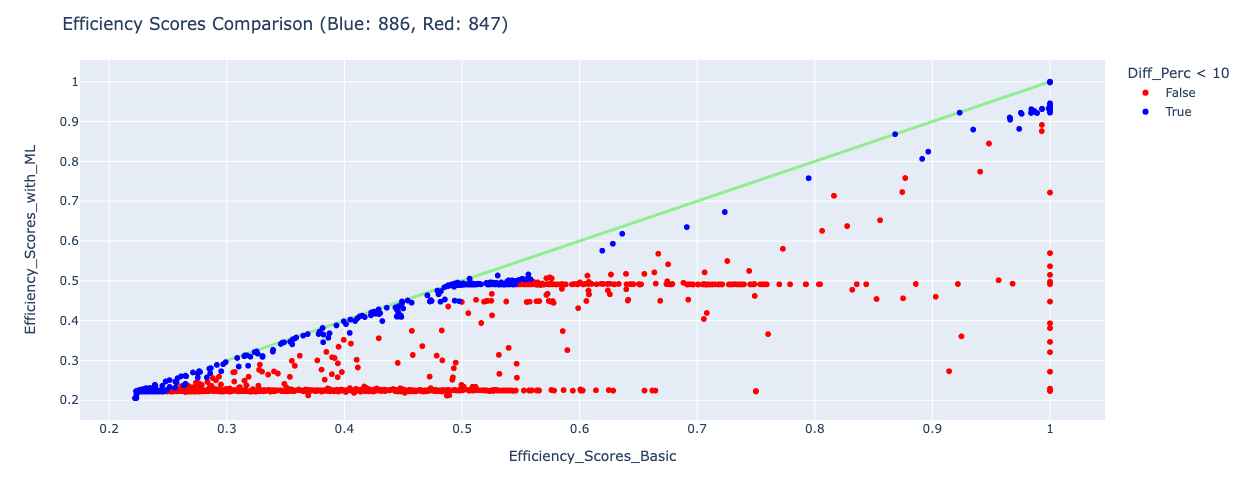

In [26]:
fig = px.scatter(df_res, x="Efficiency_Scores_Basic", y="Efficiency_Scores_with_ML", color = "Diff_Perc < 10", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Efficiency_Scores_Basic", "Efficiency_Scores_with_ML", "Diff_Perc"] + [df_res.index])

fig.add_traces(
    list(px.line(x = np.linspace(0.3, 1, num=2), y = np.linspace(0.3, 1, num=2)).select_traces())
)

fig.update_traces(line_color='lightgreen', line_width=3)

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Efficiency Scores Comparison (Blue: {blue}, Red: {red})",
)

fig.show()